In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm 
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../Data_exploration_notebooks')

from WranglerFunctions import CostsWrangler
from WranglerFunctions import F3Metl_Comp_Wrangler
from WranglerFunctions import Unemployment_Wrangler

In [2]:
RIO_costs = pd.read_csv('../Datasets/Financial_dataset/IncomeStatements/RIO_LN_BBG_GAAP.csv', index_col = False, encoding= 'unicode_escape')
RIO_costs = CostsWrangler(RIO_costs, 'Revenue')

earnings = pd.read_csv('../Datasets/Financial_dataset/F3METL_Comp.csv', index_col=False, encoding = 'unicode_escape')
earnings = F3Metl_Comp_Wrangler(earnings)

unemployment = pd.read_csv('../Datasets/Economic_dataset/Unemployment.csv', index_col=False, encoding = 'unicode_escape')
unemployment = Unemployment_Wrangler(unemployment)
unemployment = unemployment['Unemployment Rate'].to_frame()

# RIO_earnings
RIO_earnings = earnings['RIO LN Equity']['EBITDA'].to_frame()
RIO_costs = RIO_costs['Operating Expenses'].to_frame()
unemployment = unemployment.iloc[::-1]
unemployment

0


,Unemployment Rate
Date,
1971-06-30,4.00
1971-09-30,4.17
1971-12-31,4.37
1972-03-31,4.50
1972-06-30,4.47
...,...
2020-09-30,4.53
2020-12-31,5.10
2021-03-31,5.00


In [3]:
# Merge with a 3 day tolerance
op_tol = pd.Timedelta('3 day')
df = pd.merge_asof(left=RIO_costs,right=RIO_earnings,right_index=True,left_index=True,direction='nearest',tolerance=op_tol)
unemp_tol = pd.Timedelta('100 day')
df = pd.merge_asof(left=df,right=unemployment,right_index=True,left_index=True,direction='nearest',tolerance=unemp_tol)
df['Previous EBITDA'] = df['EBITDA'].shift(periods = 1)
# Discard first row after percentage change calculation
df = df.iloc[1:]
df

,Operating Expenses,EBITDA,Unemployment Rate,Previous EBITDA
Date,,,,
2011-12-31,29362.9,12893.0,8.43,13406.0
2012-12-31,33731.6,-6066.0,7.83,12893.0
2013-12-31,28437.0,8038.0,7.27,-6066.0
2014-12-31,22606.1,8399.0,5.87,8038.0
2015-12-31,20952.9,2898.0,5.13,8399.0
2016-12-31,20538.3,4367.0,4.77,2898.0
2017-12-31,20938.1,10209.0,4.30,4367.0
2018-12-31,17865.1,13251.0,4.03,10209.0
2019-12-31,25450.7,8478.0,3.80,13251.0


6
[3930.3, 9188.1, 11925.9, 7630.2, 11849.4]
Date
2017-12-31    10209.0
2018-12-31    13251.0
2019-12-31     8478.0
2020-12-31    13166.0
2021-12-31    19744.0
Name: EBITDA, dtype: float64
['2017-12-31T00:00:00.000' '2018-12-31T00:00:00.000'
 '2019-12-31T00:00:00.000' '2020-12-31T00:00:00.000'
 '2021-12-31T00:00:00.000']


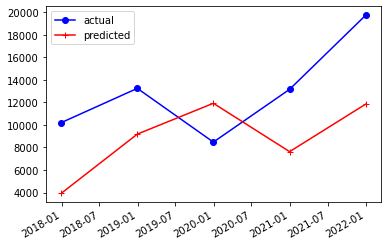

[3930.3, 9188.1, 11925.9, 7630.2, 11849.4]

In [5]:
# TODO: Calculate fractional change for each feature
# train_data, test_data = train_test_split(
#             df, test_size=0.33, shuffle=False)

# Prediction using a Hidden Markov Model and three features: fractional change in EBITDA, operating expenses, and unemployment rate
class HMM(object):
    def __init__(self, 
                 test_size=5,
                 n_hidden_states=2, 
                 n_steps_ebitda=50,
                 n_steps_unemp=10,
                 n_steps_opex=10):
        
        self.hmm = GaussianHMM(n_components=n_hidden_states)
 
        self._split_train_test_data(test_size)
 
        self._compute_all_possible_outcomes(n_steps_ebitda,
            n_steps_unemp, n_steps_opex)
 
    def _split_train_test_data(self, test_size):
        _train_data, _test_data = train_test_split(
            df, test_size=test_size, shuffle=False)
 
        self._train_data = _train_data

        print(len(_train_data))
        self._test_data = _test_data
 
    @staticmethod
    def _extract_features(df):
        ebitda = np.array(df['EBITDA'])
        unemp = np.array(df['Unemployment Rate'])
        opex = np.array(df['Operating Expenses'])
        frac_ebitda = (ebitda[1:] - ebitda[:-1]) / ebitda[:-1]
#         feature_vector = [tuple(x) for x in df[['EBITDA', 'Unemployment Rate', 'Operating Expenses']].to_numpy()]
        return np.column_stack((frac_ebitda, unemp[:-1], opex[:-1]))
 
    def fit(self):
        feature_vector = HMM._extract_features(self._train_data) 
        self.hmm.fit(feature_vector)
 
    def _compute_all_possible_outcomes(self, n_steps_ebitda,
                                       n_steps_unemp, n_steps_opex):
        frac_ebitda_range = np.linspace(-0.1, 0.1, n_steps_ebitda)
        unemp_range = np.linspace(4.0, 10.0, n_steps_unemp)
        opex_range = np.linspace(0, 35000, n_steps_opex)
        self._possible_outcomes = np.array(list(itertools.product(
            frac_ebitda_range, unemp_range, opex_range)))
 
    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = 0
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_end_index: previous_data_start_index]
        previous_data_features = HMM._extract_features(previous_data)
 
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
#             print((previous_data_features, possible_outcome))
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
 
        return most_probable_outcome
 
    def predict_close_price(self, day_index):
        previous_ebitda = self._test_data.iloc[day_index]['Previous EBITDA']
        frac_predicted_ebitda, _, _ = self._get_most_probable_outcome(day_index)
        return previous_ebitda * (1 + frac_predicted_ebitda)
 
    def predict_close_prices_for_days(self, days, with_plot=False):
        predicted_ebitda = []
        for day_index in range(days):
            predicted_ebitda.append(self.predict_close_price(day_index))
        print(predicted_ebitda)
        if with_plot:
            test_data = self._test_data[0: days]
            days = np.array(test_data.index, dtype="datetime64[ms]")
            actual_ebitda = test_data['EBITDA']
            print(actual_ebitda)

            fig = plt.figure()

            print(days)
            axes = fig.add_subplot(111)
            axes.plot(days, actual_ebitda, 'bo-', label="actual")
            axes.plot(days, predicted_ebitda, 'r+-', label="predicted")
 
            fig.autofmt_xdate()
 
            plt.legend()
            plt.show()
 
        return predicted_ebitda
model = HMM()
model.fit()
model.predict_close_prices_for_days(5, with_plot=True)